EJERCICIO 1:


In [46]:
pip install xgboost

In [47]:
import os
from os import listdir
from PIL import Image
import glob
import os.path
import pandas as pd
import numpy as np
import skimage.io as io
import skimage as sk
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import matplotlib
import xgboost
from skimage.filters import threshold_otsu
from skimage.morphology import square
from sklearn.metrics import jaccard_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score


In [48]:
# Rutas de los directorios
carpeta_sat = 'DataSet_1/roads/sat'
carpeta_gt = 'DataSet_1/roads/gt'

# Obtenemos las mágenes de satélite:
imgs_sat = []
for f in os.listdir(carpeta_sat):
    img = Image.open(os.path.join(carpeta_sat, f))
    img_np = np.array(img)
    imgs_sat.append(img_np)
    
# Obtenemos las imágenes de salida:    
imgs_gt = []
for f in os.listdir(carpeta_gt):
    img = Image.open(os.path.join(carpeta_gt, f))
    img_np = np.array(img) > 0
    imgs_gt.append(img_np)

In [49]:
def calcular_gradiente(imagen, sigma):
    der_horizontal, der_vertical = calcular_derivadas(imagen, sigma)
    return [der_horizontal, der_vertical]

def calcular_derivadas(imagen, sigma):
    der_horizontal = ndi.gaussian_filter(imagen, sigma=sigma, order=[1,0])
    der_vertical = ndi.gaussian_filter(imagen, sigma=sigma, order=[0,1])
    return der_horizontal, der_vertical

def calcular_magnitud(gradiente):
    dx, dy = gradiente
    mg = np.sqrt(dx**2 + dy**2)
    return mg

def calcular_orientacion(gradiente):
    dx, dy = gradiente
    orientacion = np.arctan2(dy, dx)
    return orientacion

def calcular_laplaciano(imagen, sigma):
    dx2 = ndi.gaussian_filter(imagen, sigma=sigma, order=[2,0])
    dy2 = ndi.gaussian_filter(imagen, sigma=sigma, order=[0,2])
    laplaciano = dx2 + dy2
    
    return laplaciano

# Canales RGB


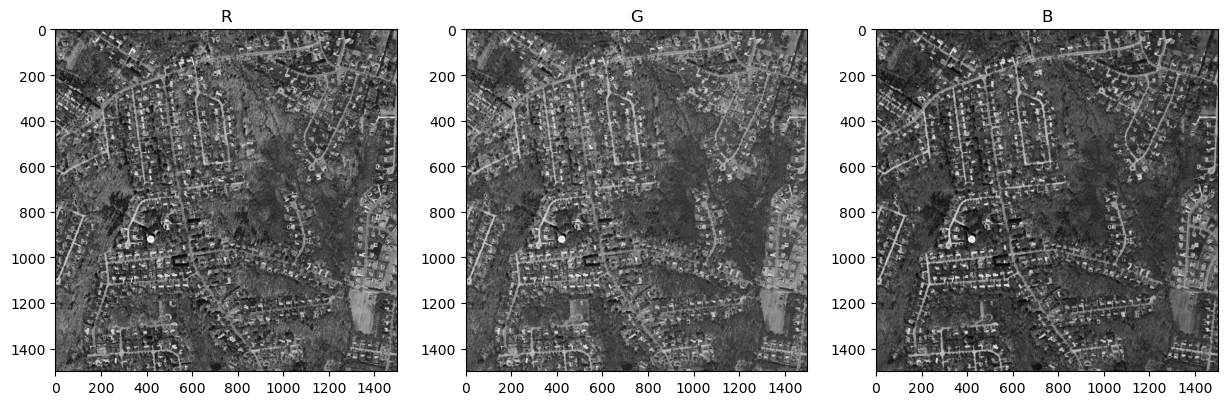

In [50]:
road_ejemplo = imgs_sat[11]

plt.rcParams["figure.figsize"] = [15, 15]

plt.subplot(131, title='R')
plt.imshow(road_ejemplo[:,:,0], cmap='gray')
plt.subplot(132, title='G')
plt.imshow(road_ejemplo[:,:,1], cmap='gray')
plt.subplot(133, title='B')
plt.imshow(road_ejemplo[:,:,2], cmap='gray')

En esta prñactica se nos presenta un total de 40 imágenes 20 satélitales y 20 binarias, que son las salidas deseadas. Lo primero que hemos de hacer es dividir los datos en tres conjuntos: Entrenamiento, validación y test. Para ello las imágenes se organizaran de la siguiente manera:

- Entrenamiento: 14 imágenes
- Validación: 3 imágenes
- Test: 3 imágenes

In [51]:
X_train = pd.DataFrame()
for i in range(14):
    r = imgs_sat[i][:, :, 0].flatten()
    g = imgs_sat[i][:, :, 1].flatten()
    b = imgs_sat[i][:, :, 2].flatten()
    df_img = pd.DataFrame()
    df_img["R"] = r
    df_img["G"] = g
    df_img["B"] = b
    X_train = pd.concat([X_train, df_img])

y_train = list()
for i in range(14):
    img = imgs_gt[i].flatten()
    y_train.append(img)

y_train = [item for sublist in y_train for item in sublist]
y_train = np.array(y_train)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {len(y_train)}")

X_val  = pd.DataFrame()
for i in range(14,17):
    r = imgs_sat[i][:, :, 0].flatten()
    g = imgs_sat[i][:, :, 1].flatten()
    b = imgs_sat[i][:, :, 2].flatten()

    df_img = pd.DataFrame()
    df_img["R"] = r
    df_img["G"] = g
    df_img["B"] = b
    X_val  = pd.concat([X_val , df_img])

y_val  = list()
for i in range(14,17):
    img = imgs_gt[i].flatten()
    y_val .append(img)

y_val  = [item for sublist in y_val  for item in sublist]
y_val = np.array(y_val)

print(f"Shape de X_val: {X_val .shape}")
print(f"Shape de y_val: {len(y_val )}")



X_test  = pd.DataFrame()
for i in range(17,20):
    r = imgs_sat[i][:, :, 0].flatten()
    g = imgs_sat[i][:, :, 1].flatten()
    b = imgs_sat[i][:, :, 2].flatten()

    df_img = pd.DataFrame()
    df_img["R"] = r
    df_img["G"] = g
    df_img["B"] = b
    X_test  = pd.concat([X_test , df_img])

y_test  = list()
for i in range(17,20):
    img = imgs_gt[i].flatten()
    y_test .append(img)

y_test  = [item for sublist in y_test  for item in sublist]
y_test = np.array(y_test)

print(f"Shape de X_test: {X_test .shape}")
print(f"Shape de y_test: {len(y_test )}")

Shape de X_train: (31500000, 3)
Shape de y_train: 31500000
Shape de X_val: (6750000, 3)
Shape de y_val: 6750000
Shape de X_test: (6750000, 3)
Shape de y_test: 6750000


In [53]:
bin_y_train = y_train > 0
bin_y_val = y_val > 0
bin_y_test = y_test > 0

In [54]:
num_trues_train = sum(bin_y_train)
num_false_train = len(bin_y_train) - num_trues_train
ratio = int(num_false_train / num_trues_train)
print(f'ratio=',ratio)

ratio= 30


In [55]:
dtrain = xgboost.DMatrix(X_train.values, label=bin_y_train)
dval = xgboost.DMatrix(X_val.values, label=bin_y_val)
dtest = xgboost.DMatrix(X_test.values) 

In [57]:
param = {'max_depth':8, 'eta':1, 'objective':'binary:logistic', 'scale_pos_weight':ratio}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [58]:
model = xgboost.train(param, dtrain, 100, watchlist, early_stopping_rounds=10)

c:\Users\pdcob\anaconda3\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.39257	val-logloss:0.40188
[1]	train-logloss:0.37183	val-logloss:0.38904
[2]	train-logloss:0.36727	val-logloss:0.38869
[3]	train-logloss:0.36663	val-logloss:0.38866
[4]	train-logloss:0.36486	val-logloss:0.38736
[5]	train-logloss:0.36425	val-logloss:0.38702
[6]	train-logloss:0.36450	val-logloss:0.38734
[7]	train-logloss:0.36464	val-logloss:0.38720
[8]	train-logloss:0.36163	val-logloss:0.38391
[9]	train-logloss:0.36203	val-logloss:0.38377
[10]	train-logloss:0.36138	val-logloss:0.38317
[11]	train-logloss:0.36160	val-logloss:0.38375
[12]	train-logloss:0.36094	val-logloss:0.38324
[13]	train-logloss:0.36127	val-logloss:0.38381
[14]	train-logloss:0.36074	val-logloss:0.38331
[15]	train-logloss:0.36090	val-logloss:0.38363
[16]	train-logloss:0.36026	val-logloss:0.38285
[17]	train-logloss:0.36060	val-logloss:0.38313
[18]	train-logloss:0.35998	val-logloss:0.38282
[19]	train-logloss:0.36058	val-logloss:0.38336
[20]	train-logloss:0.36057	val-logloss:0.38342
[21]	train-logloss:0.36

In [59]:
y_pred = model.predict(dtest)
y_pred_prueba = y_pred > 0.5

In [60]:
img1 = y_pred_prueba[0*(1500*1500) : 1*(1500*1500)]
img2 = y_pred_prueba[1*(1500*1500) : 2*(1500*1500)]
img3 = y_pred_prueba[2*(1500*1500) : 3*(1500*1500)]
print(f"Img1: {len(img1)}")
print(f"Img2: {len(img2)}")
print(f"Img3: {len(img3)}")

Img1: 2250000
Img2: 2250000
Img3: 2250000


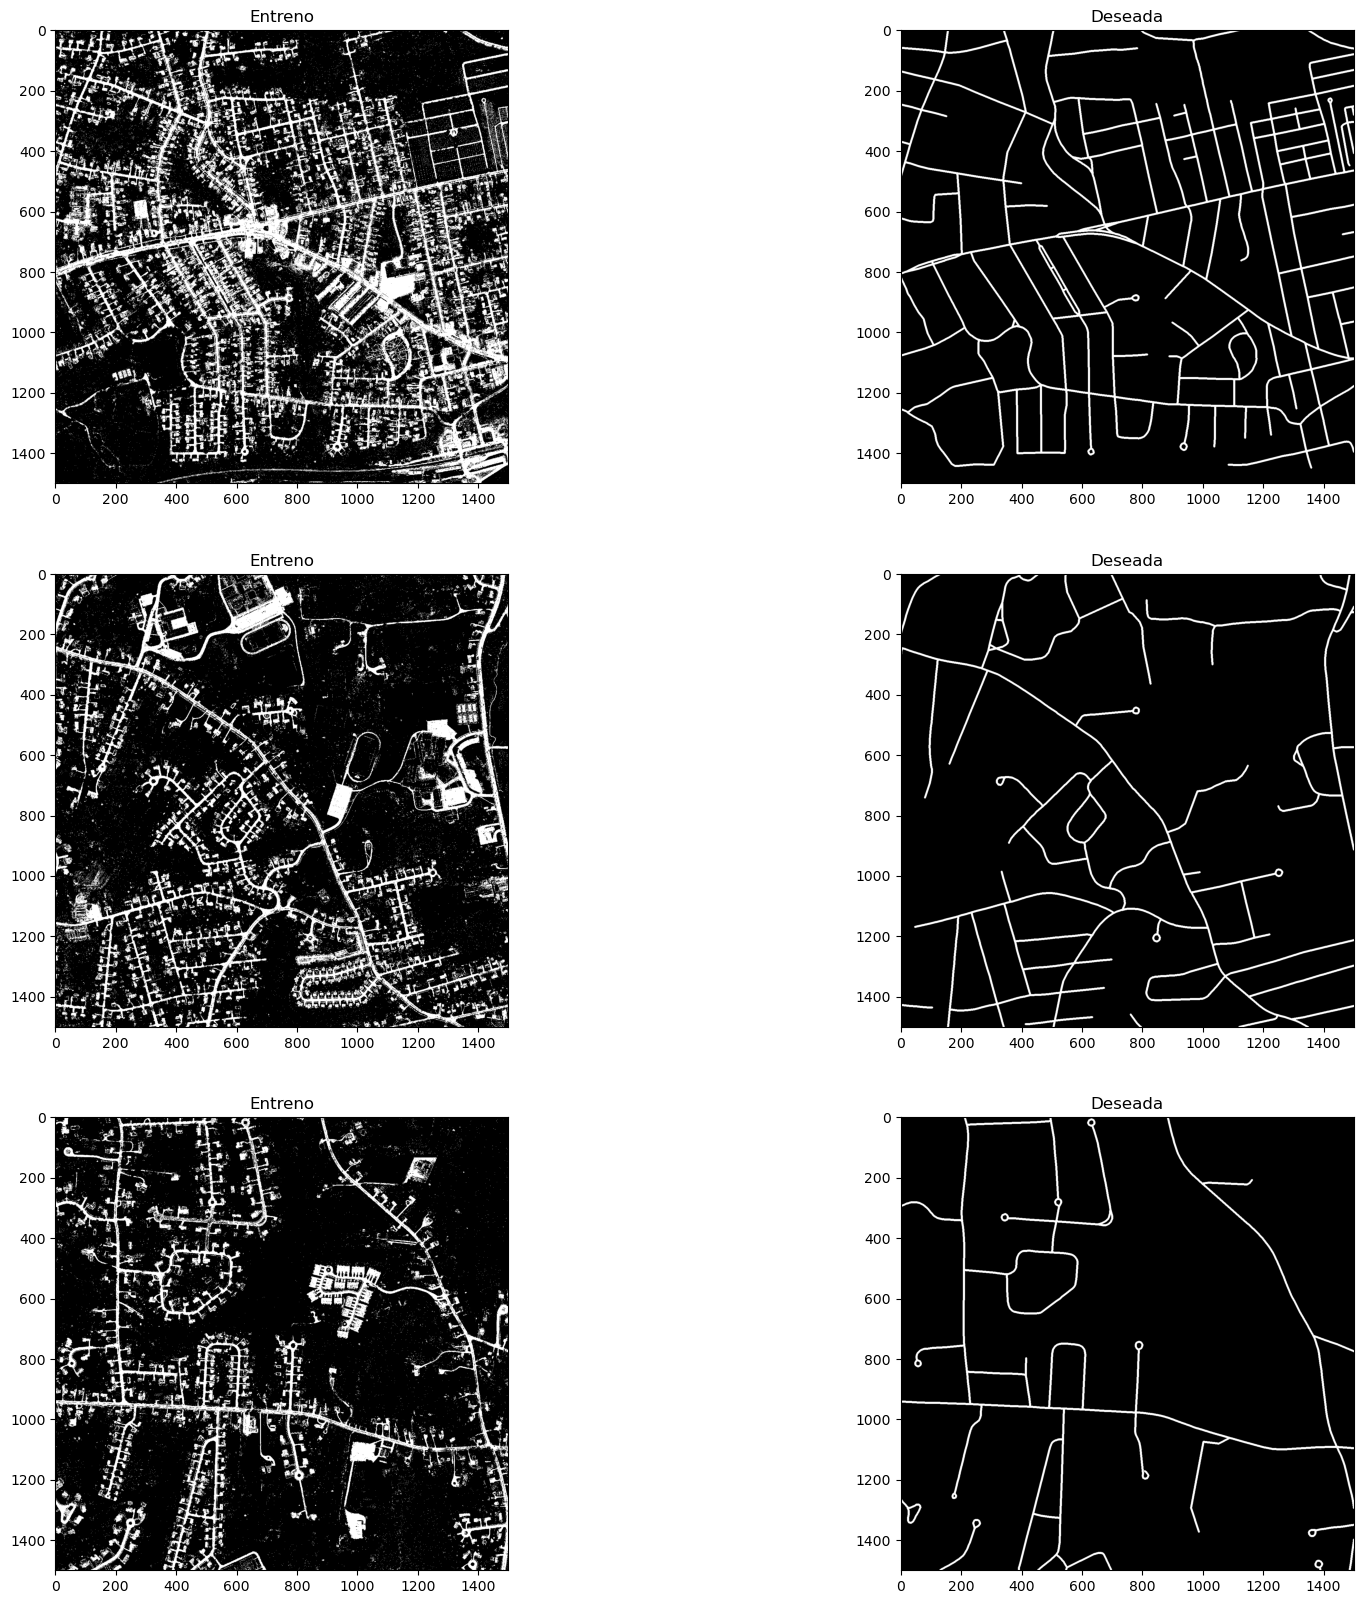

In [62]:
img1_r = np.reshape(img1, (1500, 1500))
img2_r = np.reshape(img2, (1500, 1500))
img3_r = np.reshape(img3, (1500, 1500))

plt.rcParams["figure.figsize"] = [20, 20]

plt.subplot(321, title='Entreno')
plt.imshow(img1_r, cmap='gray')
plt.subplot(322, title='Deseada')
plt.imshow(imgs_gt[17], cmap='gray')
plt.subplot(323, title='Entreno')
plt.imshow(img2_r, cmap='gray')
plt.subplot(324, title='Deseada')
plt.imshow(imgs_gt[18], cmap='gray')
plt.subplot(325, title='Entreno')
plt.imshow(img3_r, cmap='gray')
plt.subplot(326, title='Deseada')
plt.imshow(imgs_gt[19], cmap='gray')